<a href="https://colab.research.google.com/github/hamzzihyun/competition/blob/main/DACON/%ED%95%B4%EC%99%B8%EB%B6%80%EB%8F%99%EC%82%B0%EC%9B%94%EC%84%B8%EC%98%88%EC%B8%A1AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 설치
!pip install Bio
!pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [ ]:
import sys
import random
import pandas as pd
import numpy as np
import os
import torch
import pickle
from tqdm import tqdm
import Bio
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm
import sklearn
import catboost
from sklearn.metrics import f1_score
import warnings

# from pycaret.regression import *

warnings.filterwarnings(action='ignore')
print('파이썬 버전 : '+sys.version)
print('catboost 버전 : '+catboost.__version__)
print('torch 버전 : '+torch.__version__)
print('numpy 버전 : '+np.__version__)
print('pandas 버전 : '+pd.__version__)
print('sklearn 버전 : '+sklearn.__version__)
!nvidia-smi # gpu 환경 A100

파이썬 버전 : 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
catboost 버전 : 1.1.1
torch 버전 : 1.13.0+cu116
numpy 버전 : 1.21.6
pandas 버전 : 1.3.5
sklearn 버전 : 1.0.2
Sat Dec 24 06:05:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+------

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Data Load

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/DACON/해외 부동산 월세 예측 AI'

In [ ]:
train = pd.read_csv(path + '/open/train.csv')
test = pd.read_csv(path + '/open/test.csv')

In [ ]:
def get_x_y(df):
  if 'monthlyRent(us_dollar)' in df.columns:
    df_x = df.drop(columns=['ID','monthlyRent(us_dollar)'])
    df_y = df['monthlyRent(us_dollar)']
    return df_x, df_y
  else:
    df_x = df.drop(columns=['ID'])
    return df_x

In [ ]:
train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

In [ ]:
print(train_x.shape)
print(train_x.columns)
train_x.head()

(8692, 10)
Index(['propertyType', 'bedrooms', 'latitude', 'longitude', 'suburbName',
       'distanceMetro(km)', 'distanceAirport(km)', 'distanceHospital(km)',
       'distanceRailway(km)', 'area(square_meters)'],
      dtype='object')


,propertyType,bedrooms,latitude,longitude,suburbName,distanceMetro(km),distanceAirport(km),distanceHospital(km),distanceRailway(km),area(square_meters)
0,Apartment,3,28.638710,77.295822,Delhi East,0.312579,22.646032,11.726966,7.352495,83.61
1,Independent Floor,1,28.498940,77.207191,Delhi South,2.486167,13.500583,7.527761,15.877066,83.61
2,Independent Floor,3,28.714123,77.154404,Delhi North,1.528794,18.918243,17.135939,10.315737,78.97
3,Independent Floor,3,28.704330,77.149956,Other,0.967121,17.749252,16.251937,9.797817,162.58
4,Apartment,4,28.577915,77.049446,Dwarka,0.834506,4.288189,15.541840,18.179806,218.32


In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8692 entries, 0 to 8691
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   propertyType          8692 non-null   object 
 1   bedrooms              8692 non-null   int64  
 2   latitude              8692 non-null   float64
 3   longitude             8692 non-null   float64
 4   suburbName            8692 non-null   object 
 5   distanceMetro(km)     8692 non-null   float64
 6   distanceAirport(km)   8692 non-null   float64
 7   distanceHospital(km)  8692 non-null   float64
 8   distanceRailway(km)   8692 non-null   float64
 9   area(square_meters)   8692 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 679.2+ KB


In [ ]:
print(test_x.shape)
print(test_x.columns)
test_x.head()

(8693, 10)
Index(['propertyType', 'bedrooms', 'latitude', 'longitude', 'suburbName',
       'distanceMetro(km)', 'distanceAirport(km)', 'distanceHospital(km)',
       'distanceRailway(km)', 'area(square_meters)'],
      dtype='object')


,propertyType,bedrooms,latitude,longitude,suburbName,distanceMetro(km),distanceAirport(km),distanceHospital(km),distanceRailway(km),area(square_meters)
0,Independent House,1,28.644199,77.162407,Delhi Central,0.675741,12.480545,9.653289,5.706151,55.74
1,Independent Floor,3,28.724508,77.087051,West Delhi,1.992787,18.799390,21.086929,15.963967,88.26
2,Independent Floor,3,28.672693,77.103973,West Delhi,0.678442,13.190977,15.514042,11.916831,111.48
3,Independent Floor,1,28.645021,77.169235,Delhi Central,0.003422,12.968327,9.448341,5.045234,59.92
4,Independent Floor,1,28.607435,77.289627,Delhi East,0.299808,20.878677,9.180785,7.736478,27.87


In [ ]:
# feature selection
corrmat = train.corr()
print(corrmat['monthlyRent(us_dollar)'])

bedrooms                  0.632692
latitude                 -0.067949
longitude                -0.013542
distanceMetro(km)        -0.030421
distanceAirport(km)      -0.078037
distanceHospital(km)     -0.142462
distanceRailway(km)      -0.027647
area(square_meters)       0.770978
monthlyRent(us_dollar)    1.000000
Name: monthlyRent(us_dollar), dtype: float64


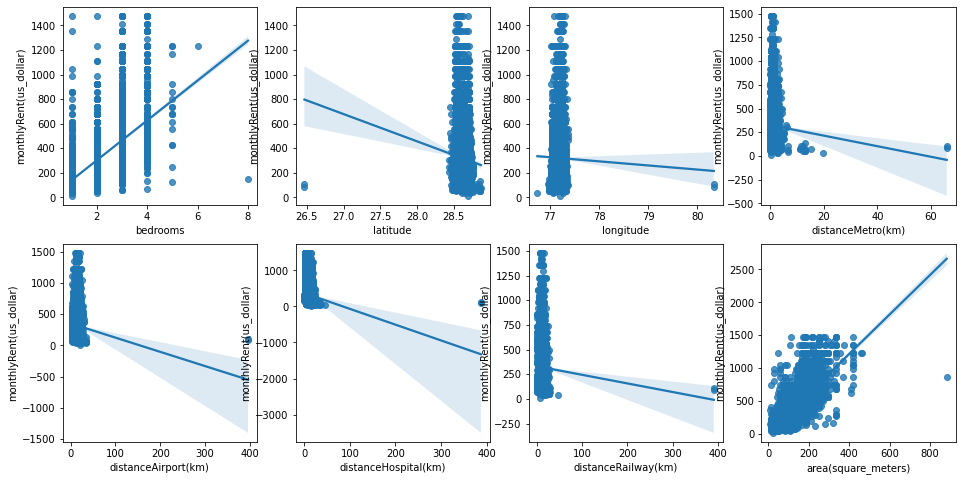

In [ ]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

lm_features = ['bedrooms','latitude','longitude','distanceMetro(km)','distanceAirport(km)',
               'distanceHospital(km)','distanceRailway(km)','area(square_meters)']
for i, feature in enumerate(lm_features):
  row = int(i/4) # 2행
  col = i%4

  sns.regplot(x=feature, y='monthlyRent(us_dollar)', data=train, ax=axs[row][col])

## Data Pre-processing

In [ ]:
# qualitative column one-hot encoding
qual_col = ['propertyType','suburbName']
ohe = OneHotEncoder(sparse=False)

for i in qual_col:
    train_x = pd.concat([train_x, pd.DataFrame(ohe.fit_transform(train_x[[i]]), columns=ohe.categories_[0])], axis=1)
    
    for qual_value in np.unique(test_x[i]): 
        if qual_value not in np.unique(ohe.categories_): 
            ohe.categories_ = np.append(ohe.categories_, qual_value)
    # One Hot Encoder가 Test 데이터로부터 Fitting되는 것은 Data Leakage이므로, Test 데이터에는 Train 데이터로 Fitting된 One Hot Encoder로부터 transform만 수행되어야 합니다.
    test_x = pd.concat([test_x, pd.DataFrame(ohe.transform(test_x[[i]]), columns=ohe.categories_[0])], axis=1)
    
train_x = train_x.drop(qual_col, axis=1)
test_x = test_x.drop(qual_col, axis=1)
print('Done.')

Done.


## Modeling

In [ ]:
X = train_x.copy()
y = train_y
X_test0 = test_x.copy()

In [ ]:
# train 및 test 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_valid.shape

((6953, 24), (1739, 24))

In [ ]:
# 평가 지표 생성
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

def RMSE(y_pred, y):
    return mean_squared_error(y_pred, y)**0.5

rmse_score = make_scorer(RMSE, greater_is_better=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [ ]:
etr=ExtraTreesRegressor(n_estimators=200)
lr=LinearRegression()
rg=Ridge()
rf=RandomForestRegressor(random_state = 42, criterion = 'mse')
gbr=GradientBoostingRegressor(random_state = 42, max_depth = 4, learning_rate=0.09, loss='huber', n_estimators=130)
xgb=XGBRegressor(random_state = 42, learning_rate=0.05, n_estimators=200)
lgb=LGBMRegressor(random_state = 42, learning_rate=0.05, n_estimators=200)
ada=AdaBoostRegressor(random_state = 42, learning_rate=0.03, n_estimators=100)
hgb=HistGradientBoostingRegressor(random_state=42, scoring=rmse_score, learning_rate=0.09)
cat_reg=CatBoostRegressor(depth = 4, random_state = 42, loss_function = 'RMSE', n_estimators = 3000, learning_rate = 0.03, verbose = 0)

In [ ]:
etr.fit(X_train,y_train)
lr.fit(X_train,y_train)
rg.fit(X_train,y_train)
rf.fit(X_train,y_train)
gbr.fit(X_train,y_train)
xgb.fit(X_train,y_train)
lgb.fit(X_train,y_train)
ada.fit(X_train,y_train)
hgb.fit(X_train,y_train)
cat_reg.fit(X_train,y_train)

[06:13:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_etr=etr.predict(X_valid)
y_lr=lr.predict(X_valid)
y_rg=rg.predict(X_valid)
y_rf=rf.predict(X_valid)
y_gbr=gbr.predict(X_valid)
y_xgb=xgb.predict(X_valid)
y_lgb=lgb.predict(X_valid)
y_ada=ada.predict(X_valid)
y_hgb=hgb.predict(X_valid)
y_cat=cat_reg.predict(X_valid)

In [ ]:
score_etr=RMSE(y_valid, y_etr)
score_lr=RMSE(y_valid, y_lr)
score_rg=RMSE(y_valid, y_rg)
score_rf=RMSE(y_valid, y_rf)
score_gbr=RMSE(y_valid, y_gbr)
score_xgb=RMSE(y_valid, y_xgb)
score_lgb=RMSE(y_valid, y_lgb)
score_ada=RMSE(y_valid, y_ada)
score_hgb=RMSE(y_valid, y_hgb)
score_cat=RMSE(y_valid, y_cat)

In [ ]:
print(score_etr)
print(score_lr)
print(score_rg)
print(score_rf)
print(score_gbr)
print(score_xgb)
print(score_lgb)
print(score_ada)
print(score_hgb)
print(score_cat)

104.7875632879067
489.3287729863109
412.49805682193386
104.57371995953588
106.28105982174984
108.0228432172248
103.10428083724939
124.07297901682087
103.69233973777838
101.99571165236516


좋은 결과를 보이고 있는 모델들만 선정해줍니다. => ETR + RF + LGB + HGB + CAT

### Kfold

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 15, random_state = 42, shuffle = True)

In [ ]:
X = train_x.copy()
# 로그변환
y = np.log1p(train_y)
target = test_x.copy()

In [ ]:
# ExtraTreesRegression
etr_pred = np.zeros(target.shape[0])
etr_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(X, y)) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], np.expm1(y.iloc[val_idx])
    
    etr = ExtraTreesRegressor(n_estimators=200)
    etr.fit(tr_x, tr_y)
    
    val_pred = np.expm1(etr.predict(val_x))
    val_rmse = RMSE(val_y, val_pred)
    etr_val.append(val_rmse)
    print(f'{n + 1} FOLD rmse = {val_rmse}')
    
    target_data = Pool(data = target, label = None)
    fold_pred = etr.predict(target) / 15
    etr_pred += fold_pred
print(f'10FOLD Mean of rmse = {np.mean(etr_val)}')

1 FOLD rmse = 111.46462737360264
2 FOLD rmse = 100.45311267239926
3 FOLD rmse = 84.54286654436915
4 FOLD rmse = 87.36257211341945
5 FOLD rmse = 93.76850366951035
6 FOLD rmse = 83.62145103573465
7 FOLD rmse = 100.34384428615095
8 FOLD rmse = 95.03663933607515
9 FOLD rmse = 107.11618307762413
10 FOLD rmse = 100.7043274681064
11 FOLD rmse = 106.10051602080082
12 FOLD rmse = 91.2549671232047
13 FOLD rmse = 101.85977634937468
14 FOLD rmse = 102.66276673753784
15 FOLD rmse = 106.1724800620179
10FOLD Mean of rmse = 98.16430892466187


In [ ]:
# RandomForestRegressor
rf_pred = np.zeros(target.shape[0])
rf_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(X, y)) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], np.expm1(y.iloc[val_idx])
    
    rf = RandomForestRegressor(random_state = 42, criterion = 'mse')
    rf.fit(tr_x, tr_y)
    
    val_pred = np.expm1(rf.predict(val_x))
    val_rmse = RMSE(val_y, val_pred)
    rf_val.append(val_rmse)
    print(f'{n + 1} FOLD rmse = {val_rmse}')
    
    fold_pred = rf.predict(target) / 15
    rf_pred += fold_pred
print(f'10FOLD Mean of rmse = {np.mean(rf_val)}')

1 FOLD rmse = 112.41418376002139
2 FOLD rmse = 103.89078080299377
3 FOLD rmse = 86.20665037166646
4 FOLD rmse = 90.57929067733687
5 FOLD rmse = 87.23886350813818
6 FOLD rmse = 84.30242808927896
7 FOLD rmse = 97.67432630211044
8 FOLD rmse = 99.0208655953665
9 FOLD rmse = 113.04323681338644
10 FOLD rmse = 96.5972960749064
11 FOLD rmse = 97.61211362394751
12 FOLD rmse = 87.52072385573098
13 FOLD rmse = 107.93487937708423
14 FOLD rmse = 98.12317238344299
15 FOLD rmse = 108.7328450464327
10FOLD Mean of rmse = 98.0594437521229


In [ ]:
# lgbr
lgb_pred = np.zeros(target.shape[0])
lgb_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(X, y)) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], np.expm1(y.iloc[val_idx])
    
    lgb = LGBMRegressor(random_state = 42, learning_rate=0.05, n_estimators=200)
    lgb.fit(tr_x, tr_y)
    
    val_pred = np.expm1(lgb.predict(val_x))
    val_rmse = RMSE(val_y, val_pred)
    lgb_val.append(val_rmse)
    print(f'{n + 1} FOLD rmse = {val_rmse}')
    
    fold_pred = lgb.predict(target) / 15
    lgb_pred += fold_pred
print(f'10FOLD Mean of rmse = {np.mean(lgb_val)}')

1 FOLD rmse = 106.6130823403455
2 FOLD rmse = 97.32133776215265
3 FOLD rmse = 83.96242097416625
4 FOLD rmse = 91.57482520332033
5 FOLD rmse = 87.35192943481192
6 FOLD rmse = 87.71865867857976
7 FOLD rmse = 95.0030718579577
8 FOLD rmse = 97.15129155267253
9 FOLD rmse = 117.44332961451924
10 FOLD rmse = 90.89965764122407
11 FOLD rmse = 97.00766546027697
12 FOLD rmse = 84.48050240847151
13 FOLD rmse = 104.72073304192041
14 FOLD rmse = 100.64262229149283
15 FOLD rmse = 101.05038370273078
10FOLD Mean of rmse = 96.19610079764284


In [ ]:
# HGBRegressor
hgbr_pred = np.zeros(target.shape[0])
hgbr_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(X, y)) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], np.expm1(y.iloc[val_idx])
    
    hgbr = HistGradientBoostingRegressor(random_state=42, scoring=rmse_score, learning_rate=0.09)
    hgbr.fit(tr_x, tr_y)
    
    val_pred = np.expm1(hgbr.predict(val_x))
    val_rmse = RMSE(val_y, val_pred)
    hgbr_val.append(val_rmse)
    print(f'{n + 1} FOLD rmse = {val_rmse}')
    
    fold_pred = hgbr.predict(target) / 15
    hgbr_pred += fold_pred
print(f'10FOLD Mean of rmse = {np.mean(hgbr_val)}')

1 FOLD rmse = 108.86974067479193
2 FOLD rmse = 99.77226582947111
3 FOLD rmse = 85.66239881922742
4 FOLD rmse = 91.55664421810432
5 FOLD rmse = 86.77973892158975
6 FOLD rmse = 89.07568455905825
7 FOLD rmse = 94.91466087985037
8 FOLD rmse = 98.06075041088347
9 FOLD rmse = 117.80360275989018
10 FOLD rmse = 91.19163330867495
11 FOLD rmse = 98.77644312134233
12 FOLD rmse = 81.56104297354545
13 FOLD rmse = 103.70162297546027
14 FOLD rmse = 98.92726920588616
15 FOLD rmse = 102.75686379658693
10FOLD Mean of rmse = 96.62735749695752


In [ ]:
# cat
cat_pred = np.zeros(target.shape[0])
cat_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(X, y)) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], np.expm1(y.iloc[val_idx])
    
    tr_data = Pool(data = tr_x, label = tr_y)
    val_data = Pool(data = val_x, label = val_y)
    
    cat = CatBoostRegressor(depth = 4, random_state = 42, loss_function = 'RMSE', n_estimators = 3000, learning_rate = 0.03, verbose = 0)
    cat.fit(tr_data, eval_set = val_data, early_stopping_rounds = 750, verbose = 1000)
    
    val_pred = np.expm1(cat.predict(val_x))
    val_rmse = RMSE(val_y, val_pred)
    cat_val.append(val_rmse)
    print(f'{n + 1} FOLD rmse = {val_rmse}')
    
    target_data = Pool(data = target, label = None)
    fold_pred = cat.predict(target) / 15
    cat_pred += fold_pred
print(f'10FOLD Mean of rmse = {np.mean(cat_val)}')

0:	learn: 0.6223971	test: 414.9445461	best: 414.9445461 (0)	total: 1.88ms	remaining: 5.64s
1000:	learn: 0.2359210	test: 414.6127467	best: 414.6127467 (1000)	total: 1.36s	remaining: 2.72s
2000:	learn: 0.2157765	test: 414.6065489	best: 414.6065370 (1989)	total: 2.71s	remaining: 1.35s
2999:	learn: 0.2032583	test: 414.6039690	best: 414.6039165 (2995)	total: 4.03s	remaining: 0us

bestTest = 414.6039165
bestIteration = 2995

Shrink model to first 2996 iterations.
1 FOLD rmse = 108.07736803500802
0:	learn: 0.6233054	test: 394.9101616	best: 394.9101616 (0)	total: 1.59ms	remaining: 4.79s
1000:	learn: 0.2355767	test: 394.6362429	best: 394.6362429 (1000)	total: 1.32s	remaining: 2.63s
2000:	learn: 0.2158552	test: 394.6313718	best: 394.6313312 (1996)	total: 2.64s	remaining: 1.32s
2999:	learn: 0.2036328	test: 394.6289767	best: 394.6289584 (2991)	total: 4.01s	remaining: 0us

bestTest = 394.6289584
bestIteration = 2991

Shrink model to first 2992 iterations.
2 FOLD rmse = 95.78901710611348
0:	learn: 0

In [ ]:
# 검증 성능 확인하기
val_list = [etr_val, rf_val, lgb_val, hgbr_val, cat_val]
for val in val_list :
  print("{:.8f}".format(np.mean(val))) 

98.16430892
98.05944375
96.19610080
96.62735750
95.07957579


In [ ]:
98.13111494
97.90444913
96.42575716
96.63385996
95.10002097

## Submit

In [ ]:
submit = pd.read_csv(path + '/open/sample_submission.csv')
submit['monthlyRent(us_dollar)']  = (np.expm1(etr_pred) + np.expm1(rf_pred) + np.expm1(lgb_pred) + np.expm1(hgbr_pred)  + np.expm1(cat_pred)) / 5
submit

,ID,monthlyRent(us_dollar)
0,Test_0000,189.291006
1,Test_0001,247.424434
2,Test_0002,323.684742
3,Test_0003,175.443744
4,Test_0004,80.123568
...,...,...
8688,Test_8688,361.326600
8689,Test_8689,344.170890
8690,Test_8690,209.311239
8691,Test_8691,162.259368


In [ ]:
submit.to_csv(path + '/제출/월세(15).csv', index=False)